#### **BG-NBD ve Gamma-Gamma ile CLTV Prediction**


 1. Verinin Hazırlanması (Data Preperation)

 2. BG-NBD Modeli ile Expected Number of Transaction

 3. Gamma-Gamma Modeli ile Expected Average Profit

 4. BG-NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması

 5. CLTV'ye Göre Segmentlerin Oluşturulması

 6. Çalışmanın fonksiyonlaştırılması

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install lifetimes   #Measuring users is hard. Lifetimes makes it easy.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Gerekli Kütüphane ve Fonksiyonlar
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [4]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
    
#kendisine girilen değer için bir eşik değer belirlemektir
#aykırı değerlere bak, ufaktan bir traşla.

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [5]:
df_ = pd.read_excel('/content/gdrive/MyDrive/DSMLBC10/week_4 (20.10.22-26.10.22)/rfm/online_retail_II.xlsx', sheet_name = "Year 2010-2011")
df = df_.copy()
print(df.describe().T)
print(df.head())
print(df.isnull().sum())

                  count       mean       std         min        25%        50%        75%        max
Quantity    541910.0000     9.5522  218.0810 -80995.0000     1.0000     3.0000    10.0000 80995.0000
Price       541910.0000     4.6111   96.7598 -11062.0600     1.2500     2.0800     4.1300 38970.0000
Customer ID 406830.0000 15287.6842 1713.6031  12346.0000 13953.0000 15152.0000 16791.0000 18287.0000
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00 2.5500   17850.0000  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00 3.3900   17850.0000  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00 2.7500   17850.0000  United Kingdom
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00 3.3900   17850.00

In [6]:
# Veri Ön İşleme
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [7]:
replace_with_thresholds(df, "Quantity")

In [8]:
replace_with_thresholds(df, "Price")

In [9]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [10]:
today_date = dt.datetime(2011, 12, 11)

In [11]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0000,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,15.3000
1,536365,71053,WHITE METAL LANTERN,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0000,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,22.0000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400


In [12]:
# Lifetime Veri Yapısının Hazırlanması

# recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde) InvoiceDate.max() - InvoiceDate.min()
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış) today_date - InvoiceDate.min()
# frequency: tekrar eden toplam satın alma sayısı (frequency>1)
# monetary: satın alma başına ortalama kazanç ##dikkat et toplam kazanç değil ortalama kazanç alınıyor RFM de toplamdı.

cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days, #farkını al gün cinsinden ifade et
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days], #T müşteri yaşı
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)

cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

cltv_df.describe().T

cltv_df = cltv_df[(cltv_df['frequency'] > 1)] #churn olmayanları bulmak için

cltv_df["recency"] = cltv_df["recency"] / 7 #recency  haftalık bazda ifadesi
cltv_df["T"] = cltv_df["T"] / 7 #müşteri yaşı haftalık bazda ifadesi

In [13]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0000,52.1429,52.5714,7,615.7143
12348.0000,40.2857,51.2857,4,442.6950
12352.0000,37.1429,42.4286,8,219.5425
12356.0000,43.1429,46.5714,3,937.1433
12358.0000,21.2857,21.5714,2,575.2100


###  **2. BG-NBD Modelinin Kurulması** **(Expected Sale Forecasting - Müşterinin Satın Alma Sayısının Modellenmesi)**

**BetaGeoFitter** fonksiyonu der ki: Bir model nesnesi oluşturacağım, fit metodu kullanarak bana *recency, frequency ve T* değerlerini verdiğinde sana bu modeli kurmuş olacağım der. Burada BG-NBD modeli **Gamma** ve **Beta** dağılımlarının parametrelerini  bulmak için, **En çok olabilirlik yönteminden** yararlanır. Tahmin yapmamıza yarar. 

Parametre bulma işlemleri sırasında bir argümana ihtiyacım var der (penalizer_coef=0.001) bu argümanımız. 

 **penalizer_coef :** Bu modelin parametrelerinin bulunması aşamasında katsayılara uygulanacak olan ceza katsayısıdır. 

 bgf = BetaGeoFitter(penalizer_coef=0.001) : model nesnem bu bunu fit ediyorum. 

**Output** fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18 değerlerini benim için buldu. Ben bulmak için uğraşmıyorum. Fakat uzun vadeli bir proje yapacaksan daha detaya inerek model geliştirmesi yapabilirsin.

In [14]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

In [15]:
# 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?

bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

# parantez içindeki  1, bir haftalık tahmini temsil etmektedir. Tamam tahmin yapacağım ama hangi
#müşterilerimiz için yap, diyoruz ve azalan şekilde sıralıyoruz.                                                 

Customer ID
12748.0000   3.2495
14911.0000   3.1264
17841.0000   1.9402
13089.0000   1.5374
14606.0000   1.4639
15311.0000   1.4336
12971.0000   1.3569
14646.0000   1.2064
13408.0000   0.9862
18102.0000   0.9685
dtype: float64

In [16]:
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

#üstteki formülde kullanılan "conditional_expected_number_of_purchases_up_to_time" uzun bunun kısası yok mu 
#diye sorguladığında "predict" te aynı işlev için kullanıldığını görebiliyoruz fakat gamma gamma da yok.
# Üstteki ile aynı.

Customer ID
12748.0000   3.2495
14911.0000   3.1264
17841.0000   1.9402
13089.0000   1.5374
14606.0000   1.4639
15311.0000   1.4336
12971.0000   1.3569
14646.0000   1.2064
13408.0000   0.9862
18102.0000   0.9685
dtype: float64

In [17]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])
cltv_df["expected_purc_1_week"]

Customer ID
12347.0000   0.1413
12348.0000   0.0920
12352.0000   0.1824
12356.0000   0.0862
12358.0000   0.1223
              ...  
18272.0000   0.1721
18273.0000   0.1043
18282.0000   0.1357
18283.0000   0.3017
18287.0000   0.1208
Name: expected_purc_1_week, Length: 2845, dtype: float64

In [18]:
# 1 ay içinde en çok satın alma beklediğimiz 10 müşteri kimdir?

bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)
# 1 yazdığımız yere 4 yazarsak 4 haftalık yani 1 aylık tahmin sonuçlarımı elde edebilirim.

Customer ID
12748.0000   12.9633
14911.0000   12.4722
17841.0000    7.7398
13089.0000    6.1330
14606.0000    5.8399
15311.0000    5.7191
12971.0000    5.4131
14646.0000    4.8119
13408.0000    3.9341
18102.0000    3.8636
dtype: float64

In [19]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635
12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668
12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271
12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435
12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862


In [20]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

# 1 aylık periyotta şirketimizin beklediği toplam satış sayısı budur. Çok değerlidir.

1776.8934732202938

In [21]:
# 3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?

bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

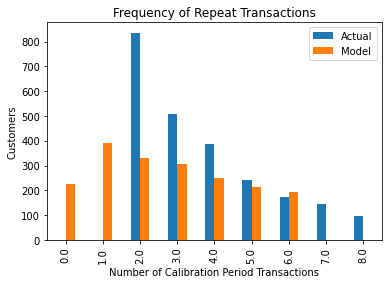

In [22]:
# Tahmin Sonuçlarının Değerlendirilmesi

plot_period_transactions(bgf)
plt.show()

#modelin tahmin ettiği ile gerçek değer kıyaslaması

# **3. GAMMA-GAMMA Modelinin Kurulması (Average Profit - Ortalama Karlılık )**

 2845 subjects, p: 3.79, q: 0.34, v: 3.73 değerlerini bizim için oluşturdu.

In [23]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [24]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

# toplam işlem sayısı ve işlem başına ortalama değer

Customer ID
12347.0000    631.9123
12348.0000    463.7460
12352.0000    224.8868
12356.0000    995.9989
12358.0000    631.9022
12359.0000   1435.0385
12360.0000    933.7905
12362.0000    532.2318
12363.0000    304.2643
12364.0000    344.1370
dtype: float64

In [25]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
12415.0000   5772.1782
12590.0000   5029.4196
12435.0000   4288.9440
12409.0000   3918.8128
14088.0000   3917.1297
18102.0000   3870.9969
12753.0000   3678.5783
14646.0000   3654.8148
15749.0000   3216.0523
14096.0000   3196.4361
dtype: float64

In [26]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

In [27]:
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5772.1782
12590.0000,0.0000,30.2857,2,4591.1725,0.0115,0.0460,0.1363,5029.4196
12435.0000,26.8571,38.2857,2,3914.9450,0.0763,0.3041,0.9035,4288.9440
12409.0000,14.7143,26.1429,3,3690.8900,0.1174,0.4674,1.3854,3918.8128
14088.0000,44.5714,46.1429,13,3864.5546,0.2603,1.0379,3.0896,3917.1297
18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,3870.9969
12753.0000,48.4286,51.8571,6,3571.5650,0.1261,0.5028,1.4973,3678.5783
14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,3654.8148
15749.0000,13.8571,47.5714,3,3028.7800,0.0280,0.1116,0.3320,3216.0523


In [28]:
# 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 aylık / aylık olmasına dikkat et
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [29]:
cltv.head() # başında beri ulaşılmak istenen nokta burasıdır fakat okunurluluğu az. Onun içinde aşağıdaki işlemler yapılacaktır.

Customer ID
12347.0000   1128.4477
12348.0000    538.8089
12352.0000    517.5000
12356.0000   1083.0903
12358.0000    966.6727
Name: clv, dtype: float64

In [30]:
#önce index problemi var onu düzeltelim.
cltv = cltv.reset_index()

In [31]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10) #clv 4. adımın olduğu formülden çıktı cltv ile aynı şey 

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,3654.8148,55741.0845
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,3870.9969,47412.5801
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,8.5526,3196.4361,29061.6614
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5772.1782,27685.1000
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,37.1641,692.3264,27377.4115
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,8.8830,2874.1987,27166.0643
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,10.4298,2110.7542,23424.4032
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,6.0476,2950.5801,18986.6123
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,5.6801,2223.8850,13440.4131
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,9.5186,1280.2183,12966.1347


Yukarıdaki tablonun analizini yapmak gerekirse Recency değeri kendi içinde bu kadar yüksek olan bu müşteriler nasıl oluyorda **cltv** için en büyük değeri vaad ediyor ? Önceden Recency düşükse iyidir diyorduk. Fakat **buy till you die** kavramı der ki senin düzenli ortalama bir işlem kapasitesi olan müşterin eğer churn olmadıysa yani dropout olmadıysa müşterinin recency değeri arttıkça satın alma olasılığı yükseliyor der. Normalde müşteri alış veriş yaptıktan sonra kısmi churn oluyordu fakat bu müşteri ihtiyaçları doğrultusunda yine gelecek. T ve Recency değeri arasında bir yakınlık varsa bunu söyleyebiliriz. Frequency ve Monetary değerleride bunu desteklemesi gerekiyor. İlk 5 e girenleri çaprazlayarak değerlendirmen gerekir.

In [32]:
# 5. CLTV'ye Göre Segmentlerin Oluşturulması
cltv_final

cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

cltv_final.sort_values(by="clv", ascending=False).head(50)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,3654.8148,55741.0845,A
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,3870.9969,47412.5801,A
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,8.5526,3196.4361,29061.6614,A
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5772.1782,27685.1000,A
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,37.1641,692.3264,27377.4115,A
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,8.8830,2874.1987,27166.0643,A
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,10.4298,2110.7542,23424.4032,A
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,6.0476,2950.5801,18986.6123,A
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,5.6801,2223.8850,13440.4131,A
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,9.5186,1280.2183,12966.1347,A


In [33]:
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                     recency                        T               frequency                  monetary                expected_purc_1_week              expected_purc_1_month              expected_purc_3_month              expected_average_profit                         clv                
                  sum count       mean        sum count    mean        sum count    mean       sum count    mean         sum count     mean                  sum count   mean                   sum count   mean                   sum count   mean                     sum count     mean          sum count      mean
segment                                                                                                                                                                                                                                                                                                                
D       11077635.0000   712 15558.4761 15716.5714   712 22.0738 28811.0000   712 40.4649      2182   712  3.0646 130981.7123   712 183.9631              50.5898   712 0.0711              201.4774   712 0.2830              598.0905   712 0.8400             141999.6650   712 199.4377  102027.4901   712  143.2970
C       10885150.0000   711 15309.6343 21806.1429   711 30.6697 27097.0000   711 38.1111      2912   711  4.0956 193174.9847   711 271.6948              85.7309   711 0.1206              341.3936   711 0.4802             1013.2176   711 1.4251             206179.7461   711 289.9856  270743.0065   711  380.7919
B       10915854.0000   711 15352.8186 20985.0000   711 29.5148 24751.1429   711 34.8117      3869   711  5.4416 265517.6312   711 373.4425             115.5066   711 0.1625              459.6926   711 0.6465             1362.6595   711 1.9165             280058.9431   711 393.8944  489356.3925   711  688.2650
A       10627572.0000   711 14947.3586 22333.1429   711 31.4109 24518.1429   711 34.4840      8076   711 11.3586 469159.4581   711 659.8586             194.4993   711 0.2736              774.3298   711 1.0891             2297.1448   711 3.2309             487674.7239   711 685.8998 1580097.9284   711 2222.3600

Müşteri başına yeni müşteri bulma maliyetini, 6 aylık periyotta müşterilerin ne kadar getiri getirdiğini hesaplayabiliriz. Örneğin expected_purc_3_month değerinin ortalamasına bakalım A ve B segmenti için 3.23 ve 1.91 gelmiş yani elimde  kaynak kısıtı varsa öncelik bu segmenttekilere yönelmek gerekir.

In [34]:
# 6. Çalışmanın Fonksiyonlaştırılması
##############################################################

def create_cltv_p(dataframe, month=3):
    # 1. Veri Ön İşleme
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7

    # 2. BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    # 3. GAMMA-GAMMA Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final


In [35]:
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [36]:
cltv_final = create_cltv_p(df)
cltv_final.head()

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,1.6784,631.9123,1128.4477,A
1,12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668,1.0920,463.7460,538.8089,B
2,12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271,2.1631,224.8868,517.5000,B
3,12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,1.0222,995.9989,1083.0903,A
4,12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862,1.4388,631.9022,966.6727,A


In [37]:
# cltv_final2.to_csv("cltv_prediction.csv")  pycharm kodu

In [38]:
cltv_final.to_csv("cltv_final.csv")
!cp cltv_final.csv "/content/gdrive/MyDrive/DSMLBC10/week_4 (20.10.22-26.10.22)/cltv_prediction"

In [39]:
df = df_.copy()
n_orders = df.groupby(["Customer ID"])["Invoice"].nunique()

In [40]:
n_orders

Customer ID
12346.0000     2
12347.0000     7
12348.0000     4
12349.0000     1
12350.0000     1
              ..
18280.0000     1
18281.0000     1
18282.0000     3
18283.0000    16
18287.0000     3
Name: Invoice, Length: 4372, dtype: int64

In [41]:
df.groupby("Customer ID").agg({"Quantity": lambda x:x.sum()})

,Quantity
Customer ID,
12346.0000,0
12347.0000,2458
12348.0000,2341
12349.0000,631
12350.0000,197
...,...
18280.0000,45
18281.0000,54
18282.0000,98


In [42]:
df.groupby("Customer ID").agg({"Invoice": lambda x:x.nunique()})

,Invoice
Customer ID,
12346.0000,2
12347.0000,7
12348.0000,4
12349.0000,1
12350.0000,1
...,...
18280.0000,1
18281.0000,1
18282.0000,3
